In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

In [6]:
!ls -alh pascalvoc-yolo.zip

In [7]:
!unzip -qq pascalvoc-yolo.zip

In [8]:
!ls -alh

# Setup and Neccessary Imports

In [9]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from matplotlib import patches
from PIL import Image

from collections import Counter

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from glob import glob

import albumentations as A
from tqdm import tqdm

# Dataset Class and DataLoader

In [10]:
class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transforms=None, mode='train'):
        self.annotations = pd.read_csv(csv_file)  # Đọc file CSV chứa thông tin nhãn
        self.img_dir = img_dir  # Đường dẫn thư mục chứa hình ảnh
        self.label_dir = label_dir  # Đường dẫn thư mục chứa nhãn
        self.S = S  # Kích thước lưới S x S
        self.B = B  # Số lượng bounding boxes
        self.C = C  # Số lượng lớp
        
        self.transform = transforms
        self.mode = mode  # Chế độ dataset ('train' hoặc 'test')

    def __len__(self):
        return len(self.annotations)

    def load_image_and_boxes(self, index):
        # Tạo đường dẫn đến file nhãn dựa vào thông tin từ CSV
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])  
        boxes = []
        # Mở file nhãn
        with open(label_path) as f:  
            # Đọc từng dòng trong file nhãn và chuyển đổi thành dạng số
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x) for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])
        # Tạo đường dẫn đến hình ảnh và mở hình ảnh
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)

        return image, boxes

    def create_mosaic(self, index):
        # Kích thước cho toàn bộ mosaic
        mosaic_size = 448
        # Kích thước cho mỗi hình ảnh con
        sub_image_size = mosaic_size // 2  

        # Khởi tạo mảng rỗng cho hình ảnh mosaic
        mosaic_image = np.full((mosaic_size, mosaic_size, 3), 255, dtype=np.uint8)

        # Biến đổi thay đổi kích thước cho mỗi hình ảnh con
        resize_transform = transforms.Resize((sub_image_size, sub_image_size), antialias=True)

        # Danh sách để lưu trữ các bounding boxes đã điều chỉnh
        mosaic_labels = []

        # Vòng lặp qua 4 phần của mosaic
        for i in range(4): 
            # Chọn một chỉ số ngẫu nhiên cho các hình ảnh bổ sung, giữ nguyên hình ảnh đầu tiên
            idx = random.randint(0, len(self) - 1) if i > 0 else index
            # Load hình ảnh và boxes
            image, boxes = self.load_image_and_boxes(idx)  
            # Thay đổi kích thước hình ảnh
            image = resize_transform(image)  
            # Chuyển hình ảnh sang dạng numpy array
            np_image = np.array(image)  

            # Tính vị trí cho mỗi hình ảnh con
            x_min = sub_image_size * (i % 2)
            y_min = sub_image_size * (i // 2)

            # Đặt hình ảnh đã thay đổi kích thước vào vị trí chính xác
            mosaic_image[y_min:y_min+sub_image_size, x_min:x_min+sub_image_size, :] = np_image

            # Điều chỉnh bounding boxes cho mỗi hình ảnh con
            for box in boxes:
                class_label, x, y, width, height = box
                x = (x * image.width + x_min) / mosaic_size
                y = (y * image.height + y_min) / mosaic_size
                width = width * image.width / mosaic_size
                height = height * image.height / mosaic_size
                mosaic_labels.append([class_label, x, y, width, height])
                
        # Chuyển đổi mảng numpy thành hình ảnh PIL
        mosaic_image = Image.fromarray(mosaic_image)  

        return mosaic_image, mosaic_labels

    def __getitem__(self, index):
        # Nếu chế độ là 'train'
        if self.mode == 'train':  
            # Xác định ngẫu nhiên xem sử dụng mosaic hay hình ảnh thông thường
            if random.random() < 0.4:
                image, boxes = self.create_mosaic(index)
            else:
                image, boxes = self.load_image_and_boxes(index)
        else:
            # Load hình ảnh và boxes bình thường
            image, boxes = self.load_image_and_boxes(index)
            
        # Áp dụng các biến đổi (nếu có)
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Tạo ma trận nhãn với kích thước (S, S, C + 5 * B)
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        boxes = torch.Tensor(boxes) 

        for box in boxes:
            # Lấy thông tin từng box
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label) 

            # Tính vị trí ô trên lưới
            i, j = int(self.S * y), int(self.S * x)  
             # Tính tọa độ x, y trong ô
            x_cell, y_cell = self.S * x - j, self.S * y - i 

            # Chuyển đổi kích thước box
            width_cell, height_cell = width * self.S, height * self.S  

            # Kiểm tra và cập nhật ma trận nhãn
            if label_matrix[i, j, 20] == 0:
                # Đánh dấu ô chứa box
                label_matrix[i, j, 20] = 1 
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                # Cập nhật tọa độ box
                label_matrix[i, j, 21:25] = box_coordinates 
                # Cập nhật nhãn lớp
                label_matrix[i, j, class_label] = 1 

        return image, label_matrix

# Other Utility Functions

In [11]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Tính toán độ chồng lấn giữa các box giới hạn
    Parameters:
        boxes_preds (tensor): Dự đoán về các box giới hạn (BATCH_SIZE, 4)
        boxes_labels (tensor): Nhãn chính xác của các box giới hạn (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, nếu box giới hạn được biểu diễn dưới dạng (x,y,w,h) hoặc (x1,y1,x2,y2)
    Returns:
        tensor: Độ chồng lấn giữa các ví dụ
    """

    # Kiểm tra nếu định dạng box là "midpoint"
    if box_format == "midpoint":
        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Tính toán tọa độ của điểm trên bên trái (x1, y1) và điểm dưới bên phải (x2, y2) cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    # Kiểm tra nếu định dạng box là "corners"
    if box_format == "corners":
        # Trích xuất tọa độ cho các box dự đoán
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)

        # Trích xuất tọa độ cho nhãn thực
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Tính toán tọa độ của hình chữ nhật giao nhau
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) dùng để xử lý trường hợp chúng không giao nhau
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Tính toán diện tích của hình chữ nhật giao nhau
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Trả về tỷ lệ độ chồng lấn giữa các box giới hạn, thêm một epsilon nhỏ để tránh chia cho 0
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [12]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Thực hiện Non-Maximum Suppression trên danh sách các box giới hạn
    Parameters:
        bboxes (list): Danh sách các box giới hạn, mỗi box được biểu diễn như [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): Ngưỡng IoU để xác định box giới hạn dự đoán là đúng
        threshold (float): Ngưỡng để loại bỏ các box giới hạn dự đoán (không phụ thuộc vào IoU)
        box_format (str): "midpoint" hoặc "corners" để chỉ định định dạng của box giới hạn
    Returns:
        list: Danh sách các box giới hạn sau khi thực hiện NMS với một ngưỡng IoU cụ thể
    """

    # Kiểm tra kiểu dữ liệu của tham số đầu vào
    assert type(bboxes) == list

    # Lọc các box giới hạn dự đoán dựa trên ngưỡng xác suất
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sắp xếp các box giới hạn theo xác suất giảm dần
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Danh sách để lưu trữ các box giới hạn sau khi thực hiện NMS
    bboxes_after_nms = []

    # Thực hiện vòng lặp cho đến khi danh sách box giới hạn rỗng
    while bboxes:
        # Lấy box giới hạn có xác suất cao nhất
        chosen_box = bboxes.pop(0)

        # Loại bỏ các box giới hạn có IoU lớn hơn ngưỡng được chỉ định với box giới hạn đã chọn
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        # Thêm box giới hạn đã chọn vào danh sách sau khi thực hiện NMS
        bboxes_after_nms.append(chosen_box)

    # Trả về danh sách các box giới hạn sau khi thực hiện NMS
    return bboxes_after_nms

In [13]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Tính giá trị trung bình độ chính xác (mAP)
    Parameters:
        pred_boxes (list): danh sách chứa các box giới hạn dự đoán với mỗi box được chỉ định như [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Tương tự như pred_boxes nhưng chứa thông tin về các box đúng
        iou_threshold (float): ngưỡng IoU, nơi các box dự đoán được coi là đúng
        box_format (str): "midpoint" hoặc "corners" được sử dụng để chỉ định định dạng của các box
        num_classes (int): số lượng lớp
    Returns:
        float: Giá trị mAP qua tất cả các lớp với một ngưỡng IoU cụ thể
    """

    # Danh sách lưu trữ mAP cho từng lớp
    average_precisions = []

    # Sử dụng để ổn định số học sau này
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Xem qua tất cả các dự đoán và mục tiêu,
        # và chỉ thêm những cái thuộc về
        # lớp c hiện tại
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Tìm số lượng box cho mỗi ví dụ huấn luyện
        # Counter ở đây tìm số lượng box đích mà chúng ta có
        # cho mỗi ví dụ huấn luyện, vì vậy giả sử ảnh 0 có 3,
        # ảnh 1 có 5 thì chúng ta sẽ có một từ điển với:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # Chúng ta sau đó duyệt qua mỗi key, val trong từ điển này
        # và chuyển đổi sang dạng sau (đối với cùng một ví dụ):
        # amount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sắp xếp theo xác suất box, index 2 là xác suất
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # Nếu không có box nào tồn tại cho lớp này thì có thể bỏ qua an toàn
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Chỉ lấy ra các box đích có cùng
            # chỉ số huấn luyện như dự đoán
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                #Chỉ detect ground truth một lần
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive và thêm box giới hạn này vào để xem
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # nếu IOU thấp hơn thì kết quả phát hiện là false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz để tích hợp số
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

# Hàm nhận một hình ảnh và danh sách các hộp giới hạn dự đoán, sau đó vẽ các hộp đó lên hình ảnh.
def plot_image(image, boxes):
    """Vẽ các hộp giới hạn dự đoán lên hình ảnh"""
    im = np.array(image)
    height, width, _ = im.shape

    # Tạo hình và trục
    fig, ax = plt.subplots(1)
    #Hiển thị hình ảnh
    ax.imshow(im)

    # box[0] là x trung điểm, box[2] là chiều rộng
    # box[1] là trung điểm y, box[3] là chiều cao

    # Tạo một hình chữ nhật
    for idx, box in enumerate(boxes):
        box = box[2:]
        assert len(box) == 4, "Có nhiều giá trị hơn x, y, w, h trong một hộp"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Thêm hình chữ nhật vào Trục
        ax.add_patch(rect)

    plt.show()
    
def push_bboxes(image, boxes, image_name=0):
    """Push bounding boxes into the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Plot the image
    ax.imshow(im)

    # box[0] is the midpoint x, box[2] is the width
    # box[1] is the midpoint y, box[3] is the height

    # Create rectangles
    for idx, box in enumerate(boxes):
        box = box[2:]
        assert len(box) == 4, "There are more values than x, y, w, h in a box"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        # Add the rectangle to the axes
        ax.add_patch(rect)

    # Save the modified image
    modified_image_path = f"{image_name}.jpg"
    plt.savefig(modified_image_path)
    plt.close(fig)

    return modified_image_path


# Hàm nhận các dự đoán từ mô hình và box thực tế từ tập dữ liệu.
# Sau đó, nó áp dụng hàm non_max_suppression để có được các box giới hạn cuối cùng
# và trả về danh sách các box giới hạn dự đoán và box thực tế.
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # Đảm bảo mô hình ở chế độ đánh giá trước khi lấy box giới hạn
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # Uncomment để hiển thị hình ảnh và hộp giới hạn dự đoán
            # if batch_idx == 0 and idx == 0:
            #     plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #     print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # Nhiều box sẽ được chuyển thành 0 nếu dự đoán
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def convert_cellboxes(predictions, S=7):
    """
    Chuyển đổi các hộp giới hạn được đầu ra từ YOLO với
    kích thước chia ảnh S thành tỷ lệ của toàn bộ ảnh
    thay vì tỷ lệ của ô. Đã thử cài đặt này
    theo cách vector hóa, nhưng nó dẫn đến mã khó đọc...
    Sử dụng như một hộp đen? Hoặc thực hiện một cài đặt
    thông minh hơn, sử dụng 2 for loops để lặp qua range(S)
    và chuyển đổi chúng một cách từng cái một, dẫn đến
    một cài đặt chậm hơn nhưng dễ đọc hơn.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

#Hàm nhận đầu ra của mô hình YOLO (đã được chuyển đổi bằng hàm convert_cellboxes)
#và chuyển đổi nó thành danh sách các hộp giới hạn.

#Mỗi box giới hạn được biểu diễn bằng một danh sách chứa thông tin như index
#của training example, class prediction, probability score, và tọa độ của box giới hạn.
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

#Hàm lưu trạng thái của mô hình và bộ tối ưu vào một tệp checkpoint. Tên tệp mặc định là "my_checkpoint.pth.tar".
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


#Hàm tải trạng thái của mô hình và bộ tối ưu từ một checkpoint đã được lưu trước đó.
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# Model Architecture

In [14]:
"""
Thông tin về cấu hình kiến trúc:
Tuple được cấu trúc bởi (kernel_size, bộ lọc, bước tiến, phần đệm)
"M" chỉ đơn giản là maxpooling với sải chân 2x2 và kernel 2x2
Danh sách được cấu trúc theo bộ dữ liệu và cuối cùng là int với số lần lặp lại
"""
# Mô tả các lớp convolution và max pooling, số lần lặp lại các khối convolution.
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

# Một khối convolution được định nghĩa với các lớp Conv2d, BatchNorm2d, và LeakyReLU.
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# Mô hình YOLOv1 được định nghĩa với các lớp convolution và các lớp fully connected layer (fcs).
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

# Hàm tạo ra các lớp convolution dựa trên cấu trúc kiến trúc đã được định nghĩa trước đó.
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

# Hàm tạo ra các lớp fully connected layer dựa trên các thông số đầu vào như kích thước ô chia, số lượng hộp, và số lớp.
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

# Loss Functions and Modules

In [15]:
# Một lớp từ nn.Module để tính toán hàm mất mát cho mô hình YOLOv1.
class YoloLoss(nn.Module):
    """
    Tính loss cho mô hình yolo (v1)
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S là kích thước chia nhỏ của ảnh (7),
        B là số hộp (2),
        C là số lớp (tập dữ liệu VOC là 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # Đây là từ Yolo, biểu thị mức độ nên làm
        # trả lỗ cho không có đối tượng (noobj) và hộp tọa độ (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Dự đoán được định hình (BATCH_SIZE, S*S(C+B*5) khi được nhập vào
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Tính IoU cho hai hộp giới hạn được dự đoán với hộp mục tiêu
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Lấy hộp có IoU cao nhất trong 2 dự đoán
        # Lưu ý bestbox sẽ có chỉ số 0, 1 bbox nào tốt nhất
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Đặt các box không có đối tượng trong đó thành 0. Lấy ra một trong hai
        # dự đoán, là dự đoán có Iou cao nhất được tính toán trước đó.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Lấy sqrt của chiều rộng, chiều cao của box để đảm bảo
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box là điểm tin cậy của bbox có IoU cao nhất
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(dự đoán[..., 20:21], dự đoán[..., 25:26])
        #no_object_loss = self.mse(
        # torch.flatten((1 - tồn tại_box) * max_no_obj, start_dim=1),
        # torch.flatten((1 - tồn tại_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # 2 hàng đầu
            + object_loss  # hàng thứ 3 in paper
            + self.lambda_noobj * no_object_loss  # hàng thứ 4
            + class_loss  # hàng thứ 5
        )

        return loss

# Training Loop

In [16]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
# Tốc độ học tập cho trình tối ưu hóa.
LEARNING_RATE = 2e-5
# Chỉ định sử dụng "cuda" (GPU) hay "cpu" để đào tạo.
DEVICE = "cuda"
# 64 trong bài báo gốc, nhưng sử dụng kích thước lô nhỏ hơn do hạn chế về GPU
BATCH_SIZE = 16
# Giảm trọng lượng cho trình tối ưu hóa để ngăn chặn việc overfitting.
WEIGHT_DECAY = 0
# Số lượng epochs đào tạo.
EPOCHS = 200
# Số lượng quy trình WORKER để tải dữ liệu.
NUM_WORKERS = 4
# Nếu Đúng, DataLoader sẽ ghim bộ nhớ để truyền dữ liệu tới GPU nhanh hơn.
PIN_MEMORY = True
# Nếu Sai, quá trình đào tạo sẽ tải mô hình được huấn luyện trước.
LOAD_MODEL = False
# Chỉ định tên tệp cho mô hình được đào tạo trước.
LOAD_MODEL_FILE = "yolov1.pth.tar"
# Thư mục chứa hình ảnh.
IMG_DIR = 'images'
# Thư mục chứa các nhãn tương ứng.
LABEL_DIR = 'labels'

In [17]:
# Kết hợp một danh sách các biến đổi ảnh và hộp giới hạn.
class Compose(object):
  # Khởi tạo đối tượng với một danh sách các biến đổi.
    def __init__(self, transforms):
        self.transforms = transforms

  # Áp dụng từng biến đổi cho ảnh và giữ nguyên các hộp giới hạn.
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
            
        bboxes = torch.Tensor(bboxes)

        return img, bboxes

# Tạo một chuỗi các biến đổi được áp dụng cho hình ảnh
transform = Compose([
    transforms.Resize((448, 448)),  # Thay đổi kích thước hình ảnh thành 448x448
    transforms.RandomApply([  # Áp dụng ngẫu nhiên một trong các biến đổi sau với xác suất 50%
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),  # Thay đổi độ sáng, tương phản, bão hòa, và màu sắc
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))  # Áp dụng làm mờ Gaussian với kích thước kernel là 3 và sigma từ 0.1 đến 2.0
    ], p=0.5),
    transforms.ToTensor(),  # Chuyển hình ảnh thành tensor PyTorch
])

# Định nghĩa hàm train_fn để huấn luyện mô hình.
def train_fn(train_loader, model, optimizer, loss_fn):
  # Sử dụng thanh tiến trình tqdm để hiển thị quá trình huấn luyện.
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    # Lặp qua từng batch, chuyển dữ liệu đầu vào và đầu ra sang DEVICE, tính loss, thực hiện lan truyền ngược và cập nhật trọng số của mô hình.
    for batch_idx, (x, y) in enumerate(loop):
        if batch_idx < 8:
            bboxes = cellboxes_to_boxes(y)
            bboxes = torch.Tensor(bboxes)
            
            img_grid = torchvision.utils.make_grid(x[0], normalize=True)
            push_bboxes(img_grid.permute(1,2,0).to("cpu"), bboxes[0].squeeze(0), batch_idx)
            
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        # Hiển thị giá trị trung bình của loss sau mỗi epoch.
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        # Cập nhật thanh tiến trình
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
  # Khởi tạo mô hình YOLOv1, tối ưu hóa Adam, và hàm mất mát YOLO.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    # Nếu có yêu cầu, tải một mô hình đã được lưu trước đó.
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    # Tạo bộ dữ liệu huấn luyện và kiểm thử (VOCDataset) với các tham số được chỉ định.
    train_dataset = VOCDataset(
        "train.csv",
        transforms = transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        mode="train",
    )

    test_dataset = VOCDataset(
        "test.csv", 
        transforms=transform, 
        img_dir=IMG_DIR, 
        label_dir=LABEL_DIR,
        mode="test",
    )

    # Tạo DataLoader cho bộ dữ liệu huấn luyện và kiểm thử với các cài đặt được chỉ định.
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # Lặp qua mỗi epoch và tính toán các hộp giới hạn dự đoán và thực tế sử dụng hàm get_bboxes.
    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )
        # Tính trung bình độ chính xác trung bình (mAP) sử dụng hàm mean_average_precision.
        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        # Nếu mAP vượt qua ngưỡng 0.5, lưu mô hình và trạng thái tối ưu hóa.
        if mean_avg_prec > 0.5:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

        # Gọi hàm huấn luyện train_fn để thực hiện quá trình huấn luyện.
        train_fn(train_loader, model, optimizer, loss_fn)

In [18]:
# Kiểm tra xem mã nguồn được thực thi trực tiếp hay được nhập vào một module khác.
# Nếu đoạn mã được thực thi trực tiếp (chứ không phải được nhập vào một module khác), hàm main() sẽ được gọi
# để bắt đầu quá trình huấn luyện và thực hiện các tác vụ chính của chương trình.
if __name__ == "__main__":
    main()

Train mAP: 0.0


100%|██████████| 1034/1034 [02:20<00:00,  7.36it/s, loss=314]  

Mean loss was 368.5022958279578


Train mAP: 0.00028775332611985505


100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s, loss=398]

Mean loss was 288.57542428287826


Train mAP: 0.0007336410926654935


100%|██████████| 1034/1034 [02:06<00:00,  8.17it/s, loss=374]

Mean loss was 273.46192307905716


Train mAP: 0.0008299920591525733


100%|██████████| 1034/1034 [02:12<00:00,  7.79it/s, loss=214]

Mean loss was 261.37100585701387


Train mAP: 0.0015836268430575728


100%|██████████| 1034/1034 [02:04<00:00,  8.30it/s, loss=198]

Mean loss was 252.77198053651438


Train mAP: 0.0017286600777879357


100%|██████████| 1034/1034 [02:12<00:00,  7.78it/s, loss=213]

Mean loss was 244.628199084815


Train mAP: 0.0014006171841174364


100%|██████████| 1034/1034 [02:10<00:00,  7.90it/s, loss=264]

Mean loss was 240.3654793567768


Train mAP: 0.0033523268066346645


100%|██████████| 1034/1034 [02:10<00:00,  7.89it/s, loss=185]

Mean loss was 231.88503452057535


Train mAP: 0.003894300665706396


100%|██████████| 1034/1034 [02:10<00:00,  7.93it/s, loss=137]

Mean loss was 224.62065515573528


Train mAP: 0.007795456796884537


100%|██████████| 1034/1034 [02:09<00:00,  7.99it/s, loss=193]

Mean loss was 218.5709283780775


Train mAP: 0.006454578600823879


100%|██████████| 1034/1034 [02:05<00:00,  8.22it/s, loss=204] 

Mean loss was 213.2586858812107


Train mAP: 0.01125179324299097


100%|██████████| 1034/1034 [02:21<00:00,  7.30it/s, loss=156]

Mean loss was 206.9261054476179


Train mAP: 0.009324165061116219


100%|██████████| 1034/1034 [02:09<00:00,  8.00it/s, loss=160]


Mean loss was 202.51306443795474
Train mAP: 0.012852844782173634


100%|██████████| 1034/1034 [02:10<00:00,  7.91it/s, loss=176]

Mean loss was 197.8448850310748


Train mAP: 0.020723314955830574


100%|██████████| 1034/1034 [02:10<00:00,  7.93it/s, loss=148]

Mean loss was 190.8581911378488


Train mAP: 0.022709451615810394


100%|██████████| 1034/1034 [02:08<00:00,  8.06it/s, loss=161]

Mean loss was 185.42844248463615


Train mAP: 0.02811666764318943


100%|██████████| 1034/1034 [02:11<00:00,  7.88it/s, loss=130]

Mean loss was 184.7101827285737


Train mAP: 0.025821631774306297


100%|██████████| 1034/1034 [02:18<00:00,  7.45it/s, loss=218]

Mean loss was 180.19505113051986


Train mAP: 0.029223274439573288


100%|██████████| 1034/1034 [02:11<00:00,  7.87it/s, loss=152]


Mean loss was 172.4294468199031
Train mAP: 0.033762745559215546


100%|██████████| 1034/1034 [02:08<00:00,  8.06it/s, loss=205] 

Mean loss was 167.41065978266053


Train mAP: 0.04769746586680412


100%|██████████| 1034/1034 [02:15<00:00,  7.61it/s, loss=189]

Mean loss was 164.41129485965928


Train mAP: 0.04823499172925949


100%|██████████| 1034/1034 [02:11<00:00,  7.86it/s, loss=166] 


Mean loss was 160.37261460413094
Train mAP: 0.05575128644704819


100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s, loss=167] 

Mean loss was 155.66777048904154


Train mAP: 0.06316886842250824


100%|██████████| 1034/1034 [02:02<00:00,  8.47it/s, loss=139] 

Mean loss was 151.44834118885504


Train mAP: 0.07039255648851395


100%|██████████| 1034/1034 [02:09<00:00,  7.99it/s, loss=154] 

Mean loss was 148.59749538340466


Train mAP: 0.07618168741464615


100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s, loss=151] 

Mean loss was 142.08414503499662


Train mAP: 0.08383886516094208


100%|██████████| 1034/1034 [02:10<00:00,  7.90it/s, loss=121] 

Mean loss was 137.87795899500009


Train mAP: 0.09262038767337799


100%|██████████| 1034/1034 [02:05<00:00,  8.23it/s, loss=112] 

Mean loss was 134.32403782119604


Train mAP: 0.08961942791938782


100%|██████████| 1034/1034 [02:08<00:00,  8.03it/s, loss=113] 

Mean loss was 129.06373530522538


Train mAP: 0.10486306250095367


100%|██████████| 1034/1034 [02:01<00:00,  8.51it/s, loss=112] 

Mean loss was 128.3391363892841


Train mAP: 0.10876878350973129


100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s, loss=131] 

Mean loss was 122.52416290120875


Train mAP: 0.11553547531366348


100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s, loss=138] 

Mean loss was 120.33902075673441


Train mAP: 0.11557295173406601


100%|██████████| 1034/1034 [02:08<00:00,  8.04it/s, loss=90.1]


Mean loss was 115.37500590650902
Train mAP: 0.12500344216823578


100%|██████████| 1034/1034 [02:07<00:00,  8.08it/s, loss=132] 

Mean loss was 112.79629731685557


Train mAP: 0.14386728405952454


100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s, loss=118] 


Mean loss was 110.05542441539654
Train mAP: 0.14097784459590912


100%|██████████| 1034/1034 [02:04<00:00,  8.32it/s, loss=107] 

Mean loss was 107.46253858451917


Train mAP: 0.16460415720939636


100%|██████████| 1034/1034 [01:58<00:00,  8.69it/s, loss=84.9]

Mean loss was 104.02443292938764


Train mAP: 0.1751410961151123


100%|██████████| 1034/1034 [02:15<00:00,  7.62it/s, loss=98.4]

Mean loss was 101.24426433334499


Train mAP: 0.200190931558609


100%|██████████| 1034/1034 [01:58<00:00,  8.74it/s, loss=96]  

Mean loss was 97.89131844850758


Train mAP: 0.19544748961925507


100%|██████████| 1034/1034 [02:00<00:00,  8.58it/s, loss=113] 

Mean loss was 96.37441635131836


Train mAP: 0.19815394282341003


100%|██████████| 1034/1034 [02:02<00:00,  8.47it/s, loss=86.5]

Mean loss was 93.85956476827654


Train mAP: 0.21728381514549255


100%|██████████| 1034/1034 [01:59<00:00,  8.63it/s, loss=65.5]

Mean loss was 90.0363313833565


Train mAP: 0.22523334622383118


100%|██████████| 1034/1034 [02:01<00:00,  8.49it/s, loss=77.5]


Mean loss was 89.1609539349259
Train mAP: 0.24199552834033966


100%|██████████| 1034/1034 [02:11<00:00,  7.87it/s, loss=92.4]

Mean loss was 86.18202257433067


Train mAP: 0.25894567370414734


100%|██████████| 1034/1034 [02:03<00:00,  8.34it/s, loss=120] 


Mean loss was 82.66446399135332
Train mAP: 0.27026188373565674


100%|██████████| 1034/1034 [02:06<00:00,  8.15it/s, loss=67]  

Mean loss was 81.12970465433206


Train mAP: 0.28384602069854736


100%|██████████| 1034/1034 [02:08<00:00,  8.06it/s, loss=85.8]

Mean loss was 79.08262756023001


Train mAP: 0.2989591658115387


100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s, loss=94.8]

Mean loss was 77.59925009618645


Train mAP: 0.29312101006507874


100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s, loss=77.2]


Mean loss was 74.84285449059374
Train mAP: 0.30671095848083496


100%|██████████| 1034/1034 [02:01<00:00,  8.53it/s, loss=39.9]

Mean loss was 76.8967831277755


Train mAP: 0.3073684275150299


100%|██████████| 1034/1034 [02:13<00:00,  7.73it/s, loss=106] 

Mean loss was 81.11638205286613


Train mAP: 0.32872912287712097


100%|██████████| 1034/1034 [02:08<00:00,  8.06it/s, loss=54.9]

Mean loss was 70.41668359177255


Train mAP: 0.34677553176879883


100%|██████████| 1034/1034 [02:02<00:00,  8.41it/s, loss=77.3]

Mean loss was 66.91926991962603


Train mAP: 0.36664706468582153


100%|██████████| 1034/1034 [02:07<00:00,  8.09it/s, loss=78.8]


Mean loss was 66.03522682927795
Train mAP: 0.3657737672328949


100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s, loss=52.8]

Mean loss was 65.24643008898029


Train mAP: 0.3788588047027588


100%|██████████| 1034/1034 [01:58<00:00,  8.70it/s, loss=71.5]

Mean loss was 64.34279357164925


Train mAP: 0.40493422746658325


100%|██████████| 1034/1034 [02:01<00:00,  8.54it/s, loss=69.9]

Mean loss was 63.31460266740456


Train mAP: 0.4039577841758728


100%|██████████| 1034/1034 [02:06<00:00,  8.19it/s, loss=78]  

Mean loss was 61.999321306697176


Train mAP: 0.4136887490749359


100%|██████████| 1034/1034 [02:08<00:00,  8.06it/s, loss=78.2]

Mean loss was 60.786952953965795


Train mAP: 0.4204750955104828


100%|██████████| 1034/1034 [02:08<00:00,  8.02it/s, loss=67.2]

Mean loss was 59.57645604043219


Train mAP: 0.4171009063720703


100%|██████████| 1034/1034 [02:02<00:00,  8.45it/s, loss=47]  

Mean loss was 57.92051952258761


Train mAP: 0.4492379128932953


100%|██████████| 1034/1034 [02:05<00:00,  8.26it/s, loss=48.5]

Mean loss was 57.4820970741877


Train mAP: 0.45581358671188354


100%|██████████| 1034/1034 [02:01<00:00,  8.52it/s, loss=53.5]

Mean loss was 56.833399455367484


Train mAP: 0.4564981460571289


100%|██████████| 1034/1034 [02:01<00:00,  8.54it/s, loss=29.4]

Mean loss was 54.250624481437285


Train mAP: 0.46708840131759644


100%|██████████| 1034/1034 [02:06<00:00,  8.15it/s, loss=51]  

Mean loss was 52.459103036434094


Train mAP: 0.4955731928348541


100%|██████████| 1034/1034 [02:04<00:00,  8.34it/s, loss=57.9]

Mean loss was 51.66715473455433


Train mAP: 0.4922370910644531


100%|██████████| 1034/1034 [02:09<00:00,  7.96it/s, loss=55.7]

Mean loss was 55.994035329763385


Train mAP: 0.49998801946640015


100%|██████████| 1034/1034 [02:13<00:00,  7.74it/s, loss=70.6]

Mean loss was 48.89001029879719


Train mAP: 0.5158223509788513
=> Saving checkpoint


100%|██████████| 1034/1034 [02:14<00:00,  7.70it/s, loss=28.7]

Mean loss was 48.017544756544396


Train mAP: 0.5124120116233826
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.10it/s, loss=37]  

Mean loss was 48.260405955508325


Train mAP: 0.527199923992157
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.93it/s, loss=56.4]

Mean loss was 47.176856459685865


Train mAP: 0.5025702118873596
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.55it/s, loss=46.8]

Mean loss was 45.479485270133104


Train mAP: 0.5283204913139343
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.29it/s, loss=22.7]

Mean loss was 44.860158930433556


Train mAP: 0.5417288541793823
=> Saving checkpoint


100%|██████████| 1034/1034 [02:08<00:00,  8.05it/s, loss=29.1]

Mean loss was 45.12613240616464


Train mAP: 0.5481878519058228
=> Saving checkpoint


100%|██████████| 1034/1034 [02:18<00:00,  7.46it/s, loss=34.8]

Mean loss was 43.900275476665975


Train mAP: 0.5498905181884766
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.92it/s, loss=37.5]

Mean loss was 42.636397225252665


Train mAP: 0.5618189573287964
=> Saving checkpoint


100%|██████████| 1034/1034 [02:16<00:00,  7.56it/s, loss=19.4]

Mean loss was 42.32772496037142


Train mAP: 0.5762231945991516
=> Saving checkpoint


100%|██████████| 1034/1034 [02:20<00:00,  7.38it/s, loss=38.8]

Mean loss was 41.17113270012507


Train mAP: 0.5989052057266235
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.92it/s, loss=27.3]

Mean loss was 40.42773470334435


Train mAP: 0.5892518758773804
=> Saving checkpoint


100%|██████████| 1034/1034 [02:16<00:00,  7.55it/s, loss=50.4]

Mean loss was 39.18843152029602


Train mAP: 0.5883656740188599
=> Saving checkpoint


100%|██████████| 1034/1034 [02:11<00:00,  7.87it/s, loss=44.2]

Mean loss was 39.381388657789394


Train mAP: 0.5811235904693604
=> Saving checkpoint


100%|██████████| 1034/1034 [02:08<00:00,  8.07it/s, loss=29.2]

Mean loss was 37.443053086906154


Train mAP: 0.6135450601577759
=> Saving checkpoint


100%|██████████| 1034/1034 [02:25<00:00,  7.08it/s, loss=20]  

Mean loss was 40.59936514122113


Train mAP: 0.6159582734107971
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.91it/s, loss=54.3]

Mean loss was 36.12964783692498


Train mAP: 0.6127644777297974
=> Saving checkpoint


100%|██████████| 1034/1034 [02:23<00:00,  7.20it/s, loss=25.8]

Mean loss was 36.05223259842834


Train mAP: 0.6201101541519165
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.15it/s, loss=27.9]

Mean loss was 35.30418149368906


Train mAP: 0.633136510848999
=> Saving checkpoint


100%|██████████| 1034/1034 [02:12<00:00,  7.81it/s, loss=30.4]

Mean loss was 35.81326786461835


Train mAP: 0.6237314939498901
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.15it/s, loss=42.8]

Mean loss was 34.38637928898145


Train mAP: 0.6025827527046204
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.53it/s, loss=47.7]

Mean loss was 34.21619278596033


Train mAP: 0.6471109986305237
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s, loss=31.7]

Mean loss was 33.50700022035226


Train mAP: 0.6499956846237183
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.57it/s, loss=36.9]

Mean loss was 33.229875056379306


Train mAP: 0.6517516374588013
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.59it/s, loss=20.2]

Mean loss was 31.552873820815833


Train mAP: 0.657152533531189
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.22it/s, loss=48.9]

Mean loss was 31.709061220028875


Train mAP: 0.6707558631896973
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.29it/s, loss=26.4]

Mean loss was 31.789729865422792


Train mAP: 0.6787792444229126
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.18it/s, loss=39.8]

Mean loss was 31.662257273838183


Train mAP: 0.6813669204711914
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.39it/s, loss=31.4]

Mean loss was 30.244942570101593


Train mAP: 0.692466139793396
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.20it/s, loss=23.5]

Mean loss was 29.361598687199606


Train mAP: 0.6897851228713989
=> Saving checkpoint


100%|██████████| 1034/1034 [02:16<00:00,  7.55it/s, loss=44.5]

Mean loss was 30.516411138457073


Train mAP: 0.6875802278518677
=> Saving checkpoint


100%|██████████| 1034/1034 [02:09<00:00,  7.99it/s, loss=17.3]

Mean loss was 28.790945569597316


Train mAP: 0.708296000957489
=> Saving checkpoint


100%|██████████| 1034/1034 [02:18<00:00,  7.49it/s, loss=20.9]

Mean loss was 28.157511590297265


Train mAP: 0.697779655456543
=> Saving checkpoint


100%|██████████| 1034/1034 [02:19<00:00,  7.43it/s, loss=30.1]

Mean loss was 29.683677075679345


Train mAP: 0.6868047714233398
=> Saving checkpoint


100%|██████████| 1034/1034 [02:08<00:00,  8.02it/s, loss=23.1]

Mean loss was 28.643181019640984


Train mAP: 0.6990877389907837
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.65it/s, loss=41.2]

Mean loss was 26.84060696430317


Train mAP: 0.6725190877914429
=> Saving checkpoint


100%|██████████| 1034/1034 [02:14<00:00,  7.71it/s, loss=21.4]

Mean loss was 26.413183959355898


Train mAP: 0.7038125991821289
=> Saving checkpoint


100%|██████████| 1034/1034 [02:09<00:00,  7.98it/s, loss=24.4]

Mean loss was 26.29093723463136


Train mAP: 0.7018073201179504
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.57it/s, loss=27.7]

Mean loss was 27.139757226468056


Train mAP: 0.7224067449569702
=> Saving checkpoint


100%|██████████| 1034/1034 [02:17<00:00,  7.53it/s, loss=20]  

Mean loss was 25.327562914134454


Train mAP: 0.7246087789535522
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s, loss=28.9]

Mean loss was 25.135466977752156


Train mAP: 0.715067982673645
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.54it/s, loss=18.5]

Mean loss was 24.72580461299166


Train mAP: 0.7149286270141602
=> Saving checkpoint


100%|██████████| 1034/1034 [01:58<00:00,  8.70it/s, loss=44]  

Mean loss was 24.2602766053589


Train mAP: 0.7221530675888062
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.64it/s, loss=24.6]

Mean loss was 23.936382152586887


Train mAP: 0.7268975973129272
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.56it/s, loss=14.8]

Mean loss was 24.100410354437173


Train mAP: 0.7237025499343872
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.66it/s, loss=13.4]

Mean loss was 23.256897975674452


Train mAP: 0.7259147763252258
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.50it/s, loss=16.7]

Mean loss was 22.763293862112256


Train mAP: 0.7381464242935181
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.20it/s, loss=15.9]

Mean loss was 21.98380242279466


Train mAP: 0.7422935366630554
=> Saving checkpoint


100%|██████████| 1034/1034 [02:13<00:00,  7.77it/s, loss=29.1]

Mean loss was 22.326111831333005


Train mAP: 0.7362892627716064
=> Saving checkpoint


100%|██████████| 1034/1034 [02:15<00:00,  7.64it/s, loss=29.5]

Mean loss was 22.27788525716018


Train mAP: 0.7558153867721558
=> Saving checkpoint


100%|██████████| 1034/1034 [02:08<00:00,  8.04it/s, loss=12.7]

Mean loss was 22.37282509683871


Train mAP: 0.7479480504989624
=> Saving checkpoint


100%|██████████| 1034/1034 [02:21<00:00,  7.33it/s, loss=20.7]

Mean loss was 22.018924169429727


Train mAP: 0.7435412406921387
=> Saving checkpoint


100%|██████████| 1034/1034 [02:09<00:00,  7.99it/s, loss=16]  

Mean loss was 21.862293621557594


Train mAP: 0.7485436797142029
=> Saving checkpoint


100%|██████████| 1034/1034 [01:58<00:00,  8.69it/s, loss=13.3]

Mean loss was 21.63264377158661


Train mAP: 0.7611221671104431
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.90it/s, loss=18.6]

Mean loss was 20.723581996600448


Train mAP: 0.7534288763999939
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.59it/s, loss=24.2]

Mean loss was 21.270944499416093


Train mAP: 0.7522144913673401
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.60it/s, loss=15.1]

Mean loss was 20.62677668326136


Train mAP: 0.7492544651031494
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.52it/s, loss=15.1]

Mean loss was 20.443429426252266


Train mAP: 0.7650994062423706
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.13it/s, loss=24.4]

Mean loss was 19.113229388655732


Train mAP: 0.7549640536308289
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.61it/s, loss=18.9]

Mean loss was 19.831507868185724


Train mAP: 0.7690223455429077
=> Saving checkpoint


100%|██████████| 1034/1034 [01:58<00:00,  8.73it/s, loss=18.5]

Mean loss was 19.029304990454847


Train mAP: 0.7672654390335083
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.13it/s, loss=16.1]

Mean loss was 20.433407830085237


Train mAP: 0.7581077814102173
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.30it/s, loss=14.7]

Mean loss was 18.87500683297502


Train mAP: 0.7731247544288635
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.64it/s, loss=24.7]

Mean loss was 18.571194672261722


Train mAP: 0.780212938785553
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.60it/s, loss=22.8]

Mean loss was 19.0818780303232


Train mAP: 0.7693569660186768
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.28it/s, loss=14.5]

Mean loss was 19.7902224460469


Train mAP: 0.7716645002365112
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.57it/s, loss=15]  

Mean loss was 18.448074237520967


Train mAP: 0.7639707326889038
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.60it/s, loss=18.7]

Mean loss was 18.76527831356115


Train mAP: 0.7614744305610657
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.92it/s, loss=11.2]

Mean loss was 18.30248161671932


Train mAP: 0.7833496928215027
=> Saving checkpoint


100%|██████████| 1034/1034 [02:15<00:00,  7.65it/s, loss=23.3]

Mean loss was 17.674679936938407


Train mAP: 0.7739996910095215
=> Saving checkpoint


100%|██████████| 1034/1034 [02:12<00:00,  7.83it/s, loss=17.8]

Mean loss was 17.455892452649497


Train mAP: 0.7804065942764282
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.58it/s, loss=14.2]

Mean loss was 18.24412363133532


Train mAP: 0.7789411544799805
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.63it/s, loss=15.9]

Mean loss was 17.18448238216009


Train mAP: 0.7767146825790405
=> Saving checkpoint


100%|██████████| 1034/1034 [02:09<00:00,  7.99it/s, loss=11.6]

Mean loss was 16.724571435548352


Train mAP: 0.7896603345870972
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.21it/s, loss=19.4]

Mean loss was 16.77962775710012


Train mAP: 0.775966465473175
=> Saving checkpoint


100%|██████████| 1034/1034 [01:58<00:00,  8.70it/s, loss=21.5]

Mean loss was 16.441340896562174


Train mAP: 0.785427987575531
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.65it/s, loss=10.2]

Mean loss was 16.797968411583966


Train mAP: 0.8025615811347961
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.62it/s, loss=15.6]

Mean loss was 16.118617316509816


Train mAP: 0.7903410196304321
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.48it/s, loss=21.7]

Mean loss was 16.01943726419711


Train mAP: 0.7832091450691223
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.63it/s, loss=10.9]

Mean loss was 15.883445599092967


Train mAP: 0.7959519028663635
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.68it/s, loss=25]  

Mean loss was 15.824759957407613


Train mAP: 0.7775387763977051
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.95it/s, loss=19.4]

Mean loss was 15.725119597676644


Train mAP: 0.796582818031311
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.19it/s, loss=17.8]

Mean loss was 15.769553469043636


Train mAP: 0.7989999055862427
=> Saving checkpoint


100%|██████████| 1034/1034 [02:11<00:00,  7.89it/s, loss=17.2]

Mean loss was 15.287954151515112


Train mAP: 0.7798195481300354
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.57it/s, loss=18.9]

Mean loss was 14.839558353276502


Train mAP: 0.7972203493118286
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s, loss=15.2]

Mean loss was 15.329447715379283


Train mAP: 0.8032024502754211
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.57it/s, loss=24.8]

Mean loss was 14.6727049585929


Train mAP: 0.7892283201217651
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.53it/s, loss=9.75]

Mean loss was 15.474156157421652


Train mAP: 0.7936643362045288
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.41it/s, loss=15.4]

Mean loss was 14.452598778837192


Train mAP: 0.7987895011901855
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.67it/s, loss=14.8]

Mean loss was 14.200466530927145


Train mAP: 0.8170178532600403
=> Saving checkpoint


100%|██████████| 1034/1034 [02:15<00:00,  7.63it/s, loss=14.9]

Mean loss was 14.096156683835117


Train mAP: 0.8141215443611145
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.65it/s, loss=11]  

Mean loss was 14.28397009220529


Train mAP: 0.8183982968330383
=> Saving checkpoint


100%|██████████| 1034/1034 [01:59<00:00,  8.67it/s, loss=18.6]

Mean loss was 13.990658775289008


Train mAP: 0.8176687955856323
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.46it/s, loss=12.7]

Mean loss was 14.019011974565295


Train mAP: 0.8041884303092957
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.19it/s, loss=11]  

Mean loss was 13.770004453465372


Train mAP: 0.8126952052116394
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.23it/s, loss=15.5]

Mean loss was 13.89059458802701


Train mAP: 0.8239477276802063
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.95it/s, loss=16.1]

Mean loss was 13.647880804607901


Train mAP: 0.8179458379745483
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.36it/s, loss=8.54]

Mean loss was 14.482984779420628


Train mAP: 0.8024352788925171
=> Saving checkpoint


100%|██████████| 1034/1034 [02:10<00:00,  7.90it/s, loss=9.21]

Mean loss was 13.119833792201325


Train mAP: 0.8040431141853333
=> Saving checkpoint


100%|██████████| 1034/1034 [02:11<00:00,  7.86it/s, loss=14.6]

Mean loss was 13.271395458935308


Train mAP: 0.830330491065979
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.53it/s, loss=13.8]

Mean loss was 14.083750069948413


Train mAP: 0.811478316783905
=> Saving checkpoint


100%|██████████| 1034/1034 [02:09<00:00,  7.98it/s, loss=13.7]

Mean loss was 13.024835015403925


Train mAP: 0.8245090246200562
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.41it/s, loss=16.5]

Mean loss was 13.31575764147871


Train mAP: 0.819739043712616
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.52it/s, loss=15.4]

Mean loss was 12.602682646284713


Train mAP: 0.8310372233390808
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.29it/s, loss=17.9]

Mean loss was 12.528871014224261


Train mAP: 0.8257032632827759
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.37it/s, loss=10.1]

Mean loss was 12.59071389411358


Train mAP: 0.8115541338920593
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.45it/s, loss=12.6]

Mean loss was 13.027384589211852


Train mAP: 0.8128341436386108
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.35it/s, loss=14.2]

Mean loss was 12.426460488391337


Train mAP: 0.8234243392944336
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.48it/s, loss=19.4]

Mean loss was 12.37073325027119


Train mAP: 0.8258445858955383
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.10it/s, loss=9.78]

Mean loss was 12.311354895163781


Train mAP: 0.8177021145820618
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.21it/s, loss=7.87]

Mean loss was 12.159723001937571


Train mAP: 0.8294821977615356
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s, loss=17.2]

Mean loss was 12.238023155662493


Train mAP: 0.8224340677261353
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.17it/s, loss=16]  

Mean loss was 12.393057033448432


Train mAP: 0.8230466842651367
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.45it/s, loss=12.3]

Mean loss was 12.21733754008605


Train mAP: 0.8271209597587585
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.52it/s, loss=9.01]

Mean loss was 11.742140155696315


Train mAP: 0.8300069570541382
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.25it/s, loss=8.52]

Mean loss was 11.248352235936103


Train mAP: 0.8294563293457031
=> Saving checkpoint


100%|██████████| 1034/1034 [02:00<00:00,  8.55it/s, loss=9.11]

Mean loss was 12.220666936103333


Train mAP: 0.8274637460708618
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.13it/s, loss=10.6]

Mean loss was 11.993619276661015


Train mAP: 0.8368943333625793
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.46it/s, loss=12.8]

Mean loss was 11.46970733268118


Train mAP: 0.8283052444458008
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.31it/s, loss=4.94]

Mean loss was 11.406128315445994


Train mAP: 0.8285974264144897
=> Saving checkpoint


100%|██████████| 1034/1034 [02:07<00:00,  8.14it/s, loss=12.1]

Mean loss was 11.43331280667731


Train mAP: 0.8312439918518066
=> Saving checkpoint


100%|██████████| 1034/1034 [02:02<00:00,  8.46it/s, loss=13.8]

Mean loss was 10.92735218794249


Train mAP: 0.8334113955497742
=> Saving checkpoint


100%|██████████| 1034/1034 [02:04<00:00,  8.33it/s, loss=4.33]

Mean loss was 11.395430384106517


Train mAP: 0.8344405889511108
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.52it/s, loss=8.64]

Mean loss was 11.242882208851826


Train mAP: 0.8271793127059937
=> Saving checkpoint


100%|██████████| 1034/1034 [02:03<00:00,  8.40it/s, loss=19.2]

Mean loss was 10.778080049520304


Train mAP: 0.8365083932876587
=> Saving checkpoint


100%|██████████| 1034/1034 [02:12<00:00,  7.83it/s, loss=28.1]

Mean loss was 11.826412096475494


Train mAP: 0.8361169695854187
=> Saving checkpoint


100%|██████████| 1034/1034 [02:01<00:00,  8.48it/s, loss=7.58]

Mean loss was 10.469406700687667


Train mAP: 0.8487294912338257
=> Saving checkpoint


100%|██████████| 1034/1034 [02:05<00:00,  8.24it/s, loss=7.68]

Mean loss was 12.717579434180859


Train mAP: 0.8332610130310059
=> Saving checkpoint


100%|██████████| 1034/1034 [01:58<00:00,  8.70it/s, loss=8.58]

Mean loss was 10.278220049186647


Train mAP: 0.8436427116394043
=> Saving checkpoint


100%|██████████| 1034/1034 [02:06<00:00,  8.17it/s, loss=5.51]

Mean loss was 10.252064862841564


Train mAP: 0.8432676196098328
=> Saving checkpoint


100%|██████████| 1034/1034 [02:13<00:00,  7.74it/s, loss=4.74]

Mean loss was 10.74728638775344


Train mAP: 0.8364426493644714
=> Saving checkpoint


 17%|█▋        | 179/1034 [00:24<01:59,  7.18it/s, loss=9.42]


KeyboardInterrupt: 

# Evaluating the model

In [21]:
# Biến LOAD_MODEL được đặt giá trị là True, chương trình sẽ tải mô hình đã được lưu trước đó
LOAD_MODEL = True


transform_test = Compose([
                    transforms.Resize((448, 448)),
                    transforms.ToTensor(),
                    ])

def main():
  # Tạo một đối tượng mô hình YOLO với các siêu tham số cụ thể.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    # Sử dụng trình tối ưu hóa Adam để tối ưu hóa các tham số của mô hình.
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    # Sử dụng hàm mất mát YOLO đã định nghĩa trước đó.
    loss_fn = YoloLoss()

    # Tải trọng số mô hình và thông tin tối ưu hóa đã được lưu trước đó từ tệp LOAD_MODEL_FILE.
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    # VOCDataset để đọc dữ liệu huấn luyện từ các tệp tin và thư mục chỉ định, sử dụng các biến siêu tham số được đặt trước.
    train_dataset = VOCDataset(
        "100examples.csv",
        transforms = transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        mode="train",
    )

    # VOCDataset để đọc dữ liệu kiểm thử từ các tệp tin và thư mục chỉ định, sử dụng các biến siêu tham số được đặt trước.
    test_dataset = VOCDataset(
        "test.csv", transforms=transform_test, 
        img_dir=IMG_DIR, 
        label_dir=LABEL_DIR,
        mode="test",
    )

    # DataLoader cho dữ liệu huấn luyện, sử dụng các siêu tham số như BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle, và drop_last đã được đặt trước.
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # DataLoader cho dữ liệu kiểm thử, sử dụng các siêu tham số như BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle, và drop_last đã được đặt trước.
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    # Hiển thị một số hình ảnh kèm theo các hộp giới hạn được dự đoán.
    for x, y in test_loader:
        x = x.to(DEVICE)
        for idx in range(8):
            bboxes = cellboxes_to_boxes(model(x))
            bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
            plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        break

=> Loading checkpoint


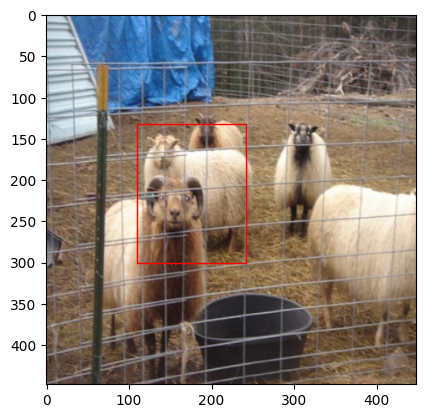

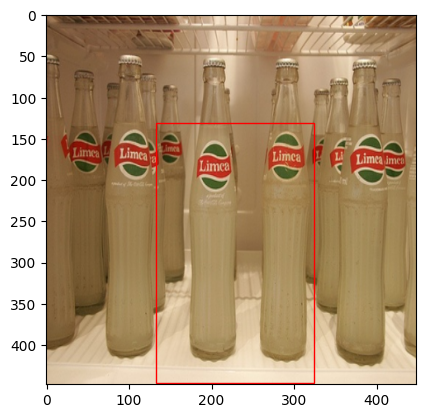

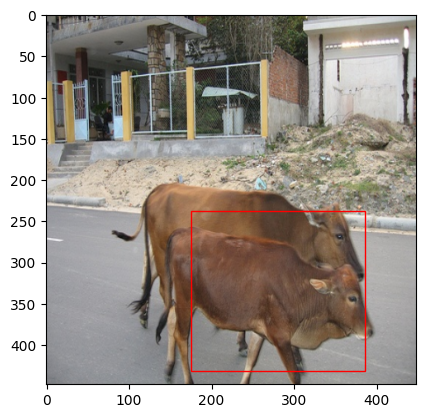

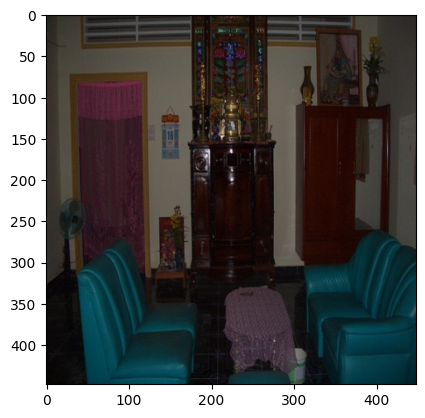

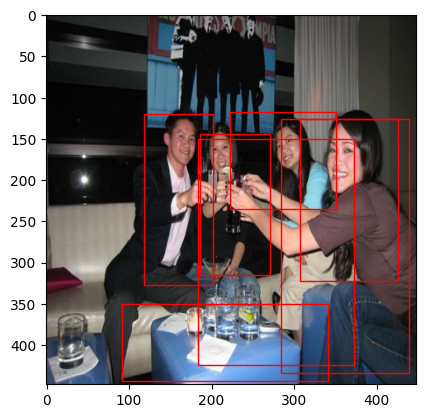

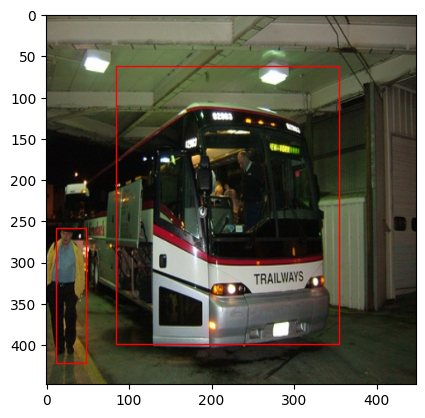

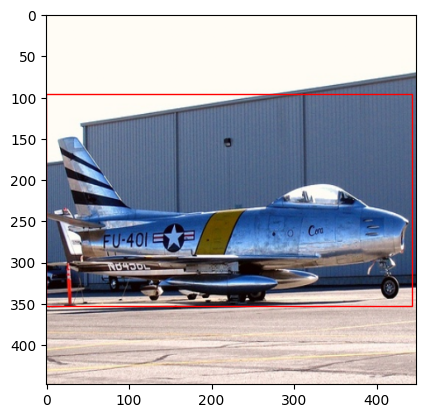

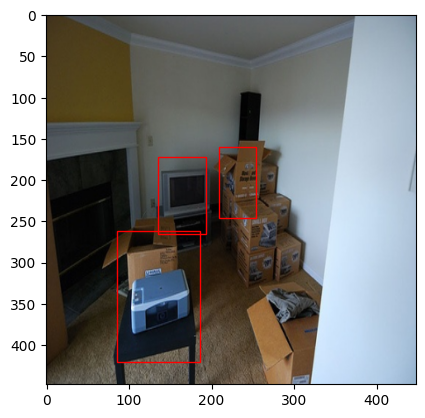

In [22]:
# Kiểm tra xem đoạn mã đang chạy
if __name__ == "__main__":
  # Bắt đầu quá trình thực thi chương trình chính.
    main()

In [ ]:
import numpy as np

boxes_preds = np.array([[[1, 2], [3, 4]],
                        [[5, 6], [7, 8]],
                        [[9, 10], [11, 12]]])
box1_x1 = boxes_preds[..., 0:1]

print(box1_x1)

In [ ]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":

      # Trích xuất tọa độ của các điểm đầu và cuối của box dự đoán và nhãn thực:
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    #Tính toán tọa độ của hình chữ nhật giao nhau:
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Tính diện tích của hình chữ nhật giao nhau (intersection):
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Tính diện tích của các box dự đoán và nhãn thực (box1_area và box2_area):
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Tính toán tỷ lệ độ chồng lấn (IoU):
    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

# Tạo tensor giả định
boxes_preds = torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]],
                            [[9, 10, 11, 12], [13, 14, 15, 16]],
                            [[17, 18, 19, 20], [21, 22, 23, 24]]], dtype=torch.float32)

boxes_labels = torch.tensor([[[0, 1, 2, 3], [4, 5, 6, 7]],
                             [[8, 9, 10, 11], [12, 13, 14, 15]],
                             [[16, 17, 18, 19], [20, 21, 22, 23]]], dtype=torch.float32)

# Gọi hàm và in kết quả
result = intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint")
print("Input (boxes_preds):")
print(boxes_preds)
print("\nInput (boxes_labels):")
print(boxes_labels)
print("\nOutput (IoU):")
print(result)


In [ ]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

def demo_iou_function():
    # Tạo tensor giả định
    boxes_preds = torch.tensor([[[1, 2, 3, 4], [5, 6, 7, 8]],
                                [[9, 10, 11, 12], [13, 14, 15, 16]],
                                [[17, 18, 19, 20], [21, 22, 23, 24]]], dtype=torch.float32)

    boxes_labels = torch.tensor([[[0, 1, 2, 3], [4, 5, 6, 7]],
                                 [[8, 9, 10, 11], [12, 13, 14, 15]],
                                 [[16, 17, 18, 19], [20, 21, 22, 23]]], dtype=torch.float32)

    # Gọi hàm và in kết quả
    result = intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint")

    print("Input (boxes_preds):")
    print(boxes_preds)
    print("\nInput (boxes_labels):")
    print(boxes_labels)
    print("\nOutput (IoU):")
    print(result)

# Gọi hàm demo
demo_iou_function()
